In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from pathlib import Path
from typing import Any, Dict, List, Optional

In [17]:
ROOT_DIR = Path("..")
DATA_DIR = ROOT_DIR / "data"
SOURCE_DIR = DATA_DIR / "source"
OUTPUT_DIR = DATA_DIR / "output"
INPUT_PATH = SOURCE_DIR / "OE_Public_Match_Data_cleaned.csv"

In [3]:
df = pd.read_csv(INPUT_PATH)
df.head()

,firsttothreetowers,firstbaron,xpdiffat,firstmidtower,golddiffat,diffkillsat,firstdragon,diffdeathsat,firsttower,firstblood,...,side,diffassistsat,split_Regular,split_Special,playoffs,firstherald,game,patch,minute,result
0,1.0,1.0,-463.0,1.0,-119.0,1.0,0.0,-1.0,1.0,1.0,...,1,3.0,1,0,0,0.0,1.0,3.15,10,1
1,1.0,1.0,63.0,1.0,1272.0,2.0,0.0,-2.0,1.0,1.0,...,1,4.0,1,0,0,0.0,1.0,3.15,15,1
2,1.0,1.0,825.0,1.0,2036.0,2.0,0.0,-2.0,1.0,1.0,...,1,4.0,1,0,0,0.0,1.0,3.15,20,1
3,1.0,1.0,4919.0,1.0,4854.0,6.0,0.0,-6.0,1.0,1.0,...,1,17.0,1,0,0,0.0,1.0,3.15,25,1
4,0.0,0.0,463.0,0.0,119.0,-1.0,1.0,1.0,0.0,0.0,...,0,-3.0,1,0,0,0.0,1.0,3.15,10,0


In [7]:
feature_columns = [col for col in df.columns if col not in ['result', 'minute']]
X = df[feature_columns].values
y = df['result'].values
weights = df['minute'].values  # Extract weights from minute column

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Weights shape: {weights.shape}")
print(f"Target distribution: {np.bincount(y)}")
print(f"Weights stats - min: {weights.min()}, max: {weights.max()}, mean: {weights.mean():.2f}")

# Split data including weights
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val, weights_train, weights_val = train_test_split(
    X_train, y_train, weights_train, test_size=0.25, random_state=42, stratify=y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train_scaled.shape}, {y_train.shape}, weights: {weights_train.shape}")
print(f"Validation set: {X_val_scaled.shape}, {y_val.shape}, weights: {weights_val.shape}")
print(f"Test set: {X_test_scaled.shape}, {y_test.shape}, weights: {weights_test.shape}")

Features shape: (731240, 19)
Target shape: (731240,)
Weights shape: (731240,)
Target distribution: [365792 365448]
Weights stats - min: 10, max: 25, mean: 17.50
Train set: (438744, 19), (438744,), weights: (438744,)
Validation set: (146248, 19), (146248,), weights: (146248,)
Test set: (146248, 19), (146248,), weights: (146248,)
Train set: (438744, 19), (438744,), weights: (438744,)
Validation set: (146248, 19), (146248,), weights: (146248,)
Test set: (146248, 19), (146248,), weights: (146248,)


# Loss function

In [8]:
class WeightedLogisticRegression:
    """
    Logistic Regression with weighted loss function.
    
    Implements: WeightedLogLoss(y, p, α) = - (1/Σαᵢ) Σ αᵢ(yᵢlog(pᵢ) + (1-yᵢ)log(1-pᵢ))
    """
    def __init__(self):
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def _compute_loss(self, X, y, sample_weights=None):
        """
        Compute weighted logistic loss.
        
        Args:
            X: Input features
            y: True labels
            sample_weights: Sample weights (α in the formula)
        """
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        predictions = np.clip(predictions, 1e-15, 1 - 1e-15)
        
        if sample_weights is None:
            # Standard unweighted loss
            loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        else:
            # Weighted loss: - (1/Σαᵢ) Σ αᵢ(yᵢlog(pᵢ) + (1-yᵢ)log(1-pᵢ))
            weighted_log_loss = sample_weights * (y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
            loss = -np.sum(weighted_log_loss) / np.sum(sample_weights)
        
        return loss

    def _compute_gradient(self, X, y, sample_weights=None):
        """
        Compute gradients for weighted logistic regression.
        
        Args:
            X: Input features
            y: True labels 
            sample_weights: Sample weights (α in the formula)
        """
        z = X @ self.weights + self.bias
        predictions = self._sigmoid(z)
        
        if sample_weights is None:
            # Standard unweighted gradients
            dw = (1 / len(y)) * X.T @ (predictions - y)
            db = (1 / len(y)) * np.sum(predictions - y)
        else:
            # Weighted gradients: (1/Σαᵢ) Σ αᵢ(pᵢ - yᵢ)
            weighted_errors = sample_weights * (predictions - y)
            weight_sum = np.sum(sample_weights)
            dw = X.T @ weighted_errors / weight_sum
            db = np.sum(weighted_errors) / weight_sum
            
        return dw, db

    def predict_proba(self, X):
        z = X @ self.weights + self.bias
        return self._sigmoid(z)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# Config

In [5]:
MAX_EPOCHS = 20000
EARLY_STOP_THRESHOLD = 1e-6

# Optimization

## SGD fixed learning rate

In [10]:
class SGDOptimizer:    
    def __init__(self, learning_rate=0.01, max_epochs=MAX_EPOCHS, early_stop_patience=50, 
                 early_stop_threshold=EARLY_STOP_THRESHOLD, log_interval=10, verbose=True):
        """
        Initialize SGD optimizer.
        
        Args:
            learning_rate (float): Fixed learning rate for gradient descent
            max_epochs (int): Maximum number of training epochs
            early_stop_patience (int): Number of epochs to wait for improvement before stopping
            early_stop_threshold (float): Minimum improvement threshold for early stopping
            log_interval (int): Log metrics every n epochs
            verbose (bool): Whether to print training progress
        """
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.log_interval = log_interval
        self.verbose = verbose
        
        # Training history
        self.loss_history = []
        self.epoch_history = []
        self.stopped_early = False
        self.final_epoch = 0
        
    def optimize(self, model, X_train, y_train, X_val=None, y_val=None, 
                weights_train=None, weights_val=None):
        """
        Optimize model parameters using SGD with early stopping.
        
        Args:
            model: Model object with _compute_loss and _compute_gradient methods
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)
            weights_train: Training sample weights (optional)
            weights_val: Validation sample weights (optional)
            
        Returns:
            dict: Training history and statistics
        """
        # Initialize weights if not already done
        if model.weights is None:
            model.weights = np.random.normal(0, 0.01, X_train.shape[1])
            model.bias = 0.0
            
        # Track best loss for early stopping
        best_loss = float('inf')
        patience_counter = 0
        
        if self.verbose:
            print(f"Starting SGD training with learning rate: {self.learning_rate}")
            print(f"Early stopping: patience={self.early_stop_patience}, threshold={self.early_stop_threshold}")
            if weights_train is not None:
                print(f"Using weighted loss with training weights shape: {weights_train.shape}")
            print("-" * 60)
            
        start_time = time.time()
        
        for epoch in range(self.max_epochs):
            # Compute loss and gradients (weighted if weights provided)
            train_loss = model._compute_loss(X_train, y_train, weights_train)
            dw, db = model._compute_gradient(X_train, y_train, weights_train)
            
            # Update parameters
            model.weights -= self.learning_rate * dw
            model.bias -= self.learning_rate * db
            
            # Store history
            self.loss_history.append(train_loss)
            self.epoch_history.append(epoch)
            
            # Check for early stopping
            if train_loss < best_loss - self.early_stop_threshold:
                best_loss = train_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            # Log progress
            if (epoch + 1) % self.log_interval == 0 and self.verbose:
                val_loss_str = ""
                if X_val is not None and y_val is not None:
                    val_loss = model._compute_loss(X_val, y_val, weights_val)
                    val_loss_str = f", Val Loss: {val_loss:.6f}"
                    
                elapsed_time = time.time() - start_time
                print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss:.6f}{val_loss_str} | "
                      f"LR: {self.learning_rate:.4f} | Patience: {patience_counter:2d}/{self.early_stop_patience} | "
                      f"Time: {elapsed_time:.2f}s")
                
            # Early stopping check
            if patience_counter >= self.early_stop_patience:
                self.stopped_early = True
                self.final_epoch = epoch + 1
                if self.verbose:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    print(f"No improvement in loss for {self.early_stop_patience} epochs "
                          f"(threshold: {self.early_stop_threshold})")
                break
                
        if not self.stopped_early:
            self.final_epoch = self.max_epochs
            if self.verbose:
                print(f"\nTraining completed after {self.max_epochs} epochs")
                
        training_time = time.time() - start_time
        final_loss = self.loss_history[-1]
        
        if self.verbose:
            print(f"Final loss: {final_loss:.6f}")
            print(f"Total training time: {training_time:.2f}s")
            print(f"Average time per epoch: {training_time/self.final_epoch:.4f}s")
            
        return {
            'loss_history': self.loss_history.copy(),
            'epoch_history': self.epoch_history.copy(),
            'final_loss': final_loss,
            'final_epoch': self.final_epoch,
            'stopped_early': self.stopped_early,
            'training_time': training_time,
            'learning_rate': self.learning_rate
        }
    
    def plot_loss_curve(self, title="SGD Loss Curve"):
        """Plot the loss curve from training history."""
        if not self.loss_history:
            print("No training history available. Run optimize() first.")
            return
            
        plt.figure(figsize=(10, 6))
        plt.plot(self.epoch_history, self.loss_history, 'b-', linewidth=2, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{title} (LR: {self.learning_rate})')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        if self.stopped_early:
            plt.axvline(x=self.final_epoch-1, color='r', linestyle='--', alpha=0.7, 
                       label=f'Early Stop (Epoch {self.final_epoch})')
            plt.legend()
            
        plt.tight_layout()
        plt.show()

## SGD backtracking line search

In [11]:
class SGDBacktrackingOptimizer:
    """
    Stochastic Gradient Descent with Backtracking Line Search.
    
    Features:
    - Adaptive step size using Armijo line search condition
    - Backtracking algorithm with configurable parameters
    - Early stopping based on loss improvement threshold
    - Configurable logging intervals
    - Step size history tracking
    - Support for weighted loss computation
    """
    
    def __init__(self, initial_learning_rate=1.0, c1=1e-4, rho=0.5, max_epochs=MAX_EPOCHS, 
                 early_stop_patience=50, early_stop_threshold=EARLY_STOP_THRESHOLD, log_interval=10, 
                 max_backtrack_iter=20, verbose=True):
        """
        Initialize SGD Backtracking optimizer.
        
        Args:
            initial_learning_rate (float): Initial step size for backtracking
            c1 (float): Armijo condition parameter (0 < c1 < 1)
            rho (float): Step size reduction factor (0 < rho < 1)
            max_epochs (int): Maximum number of training epochs
            early_stop_patience (int): Number of epochs to wait for improvement before stopping
            early_stop_threshold (float): Minimum improvement threshold for early stopping
            log_interval (int): Log metrics every n epochs
            max_backtrack_iter (int): Maximum backtracking iterations per epoch
            verbose (bool): Whether to print training progress
        """
        self.initial_learning_rate = initial_learning_rate
        self.c1 = c1  # Armijo parameter
        self.rho = rho  # Step reduction factor
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.log_interval = log_interval
        self.max_backtrack_iter = max_backtrack_iter
        self.verbose = verbose
        
        # Training history
        self.loss_history = []
        self.epoch_history = []
        self.step_size_history = []
        self.backtrack_iterations_history = []
        self.stopped_early = False
        self.final_epoch = 0
        
    def _armijo_condition(self, f_current, f_new, grad_dot_direction, step_size):
        """
        Check Armijo sufficient decrease condition.
        
        Args:
            f_current: Current function value
            f_new: New function value after step
            grad_dot_direction: Gradient dot product with search direction
            step_size: Current step size
            
        Returns:
            bool: True if Armijo condition is satisfied
        """
        return f_new <= f_current + self.c1 * step_size * grad_dot_direction
    
    def _backtracking_line_search(self, model, X, y, current_weights, current_bias, 
                                  dw, db, current_loss, sample_weights=None):
        """
        Perform backtracking line search to find suitable step size.
        
        Args:
            model: Model object
            X: Input features
            y: Target values
            current_weights: Current weight parameters
            current_bias: Current bias parameter
            dw: Weight gradients
            db: Bias gradient
            current_loss: Current loss value
            sample_weights: Sample weights for weighted loss computation
            
        Returns:
            tuple: (step_size, backtrack_iterations)
        """
        step_size = self.initial_learning_rate
        
        # Compute gradient norm squared (for descent direction)
        grad_norm_sq = np.sum(dw**2) + db**2
        
        # Search direction is negative gradient
        direction_dot_grad = -grad_norm_sq
        
        backtrack_iter = 0
        
        for i in range(self.max_backtrack_iter):
            # Try step with current step size
            new_weights = current_weights - step_size * dw
            new_bias = current_bias - step_size * db
            
            # Temporarily update model parameters to compute new loss
            old_weights = model.weights.copy()
            old_bias = model.bias
            
            model.weights = new_weights
            model.bias = new_bias
            
            new_loss = model._compute_loss(X, y, sample_weights)
            
            # Restore original parameters
            model.weights = old_weights
            model.bias = old_bias
            
            # Check Armijo condition
            if self._armijo_condition(current_loss, new_loss, direction_dot_grad, step_size):
                break
                
            # Reduce step size
            step_size *= self.rho
            backtrack_iter += 1
            
        return step_size, backtrack_iter
        
    def optimize(self, model, X_train, y_train, X_val=None, y_val=None,
                weights_train=None, weights_val=None):
        """
        Optimize model parameters using SGD with backtracking line search.
        
        Args:
            model: Model object with _compute_loss and _compute_gradient methods
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)
            weights_train: Training sample weights (optional)
            weights_val: Validation sample weights (optional)
            
        Returns:
            dict: Training history and statistics
        """
        # Initialize weights if not already done
        if model.weights is None:
            model.weights = np.random.normal(0, 0.01, X_train.shape[1])
            model.bias = 0.0
            
        # Track best loss for early stopping
        best_loss = float('inf')
        patience_counter = 0
        
        if self.verbose:
            print(f"Starting SGD with Backtracking Line Search")
            print(f"Initial step size: {self.initial_learning_rate}, c1: {self.c1}, rho: {self.rho}")
            print(f"Early stopping: patience={self.early_stop_patience}, threshold={self.early_stop_threshold}")
            if weights_train is not None:
                print(f"Using weighted loss with training weights shape: {weights_train.shape}")
            print("-" * 80)
            
        start_time = time.time()
        
        for epoch in range(self.max_epochs):
            # Compute loss and gradients (weighted if weights provided)
            train_loss = model._compute_loss(X_train, y_train, weights_train)
            dw, db = model._compute_gradient(X_train, y_train, weights_train)
            
            # Perform backtracking line search
            step_size, backtrack_iter = self._backtracking_line_search(
                model, X_train, y_train, model.weights, model.bias, dw, db, train_loss, weights_train
            )
            
            # Update parameters with found step size
            model.weights -= step_size * dw
            model.bias -= step_size * db
            
            # Store history
            self.loss_history.append(train_loss)
            self.epoch_history.append(epoch)
            self.step_size_history.append(step_size)
            self.backtrack_iterations_history.append(backtrack_iter)
            
            # Check for early stopping
            if train_loss < best_loss - self.early_stop_threshold:
                best_loss = train_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            # Log progress
            if (epoch + 1) % self.log_interval == 0 and self.verbose:
                val_loss_str = ""
                if X_val is not None and y_val is not None:
                    val_loss = model._compute_loss(X_val, y_val, weights_val)
                    val_loss_str = f", Val Loss: {val_loss:.6f}"
                    
                elapsed_time = time.time() - start_time
                avg_step_size = np.mean(self.step_size_history[-self.log_interval:])
                avg_backtrack = np.mean(self.backtrack_iterations_history[-self.log_interval:])
                
                print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss:.6f}{val_loss_str} | "
                      f"Step Size: {step_size:.6f} | Avg Step: {avg_step_size:.6f} | "
                      f"Backtrack: {backtrack_iter:2d} | Avg BT: {avg_backtrack:.1f} | "
                      f"Patience: {patience_counter:2d}/{self.early_stop_patience} | Time: {elapsed_time:.2f}s")
                
            # Early stopping check
            if patience_counter >= self.early_stop_patience:
                self.stopped_early = True
                self.final_epoch = epoch + 1
                if self.verbose:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    print(f"No improvement in loss for {self.early_stop_patience} epochs "
                          f"(threshold: {self.early_stop_threshold})")
                break
                
        if not self.stopped_early:
            self.final_epoch = self.max_epochs
            if self.verbose:
                print(f"\nTraining completed after {self.max_epochs} epochs")
                
        training_time = time.time() - start_time
        final_loss = self.loss_history[-1]
        
        if self.verbose:
            print(f"Final loss: {final_loss:.6f}")
            print(f"Total training time: {training_time:.2f}s")
            print(f"Average time per epoch: {training_time/self.final_epoch:.4f}s")
            print(f"Average step size: {np.mean(self.step_size_history):.6f}")
            print(f"Final step size: {self.step_size_history[-1]:.6f}")
            print(f"Average backtrack iterations: {np.mean(self.backtrack_iterations_history):.2f}")
            
        return {
            'loss_history': self.loss_history.copy(),
            'epoch_history': self.epoch_history.copy(),
            'step_size_history': self.step_size_history.copy(),
            'backtrack_iterations_history': self.backtrack_iterations_history.copy(),
            'final_loss': final_loss,
            'final_epoch': self.final_epoch,
            'stopped_early': self.stopped_early,
            'training_time': training_time,
            'initial_learning_rate': self.initial_learning_rate,
            'avg_step_size': np.mean(self.step_size_history),
            'final_step_size': self.step_size_history[-1],
            'avg_backtrack_iterations': np.mean(self.backtrack_iterations_history)
        }
    
    def plot_training_curves(self, title="SGD Backtracking Training Curves"):
        """Plot loss curve and step size evolution."""
        if not self.loss_history:
            print("No training history available. Run optimize() first.")
            return
            
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
        
        # Plot 1: Loss curve
        ax1.plot(self.epoch_history, self.loss_history, 'b-', linewidth=2, label='Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'{title} - Loss Evolution')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        if self.stopped_early:
            ax1.axvline(x=self.final_epoch-1, color='r', linestyle='--', alpha=0.7, 
                       label=f'Early Stop (Epoch {self.final_epoch})')
            ax1.legend()
        
        # Plot 2: Step size evolution
        ax2.plot(self.epoch_history, self.step_size_history, 'g-', linewidth=2, label='Step Size')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Step Size')
        ax2.set_title('Step Size Evolution')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.set_yscale('log')  # Log scale for better visualization
        
        # Plot 3: Backtrack iterations
        ax3.plot(self.epoch_history, self.backtrack_iterations_history, 'r-', linewidth=2, 
                label='Backtrack Iterations')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Backtrack Iterations')
        ax3.set_title('Backtracking Iterations per Epoch')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
            
        plt.tight_layout()
        plt.show()

## SGD iterations (mini-batch)

In [6]:
class SGDIterationsOptimizer:
    """
    Stochastic Gradient Descent optimizer that processes data by iterations (mini-batches).
    
    Features:
    - Configurable batch size for mini-batch processing
    - Iteration-based training (not epoch-based)
    - Random sampling of batches from training data
    - Early stopping based on loss improvement threshold
    - Configurable logging intervals
    - Support for weighted loss computation
    - Maintains data integrity with proper indexing
    """
    
    def __init__(self, learning_rate=0.01, batch_size=32, max_iterations=10000, 
                 early_stop_patience=100, early_stop_threshold=EARLY_STOP_THRESHOLD, 
                 log_interval=100, verbose=True):
        """
        Initialize SGD Iterations optimizer.
        
        Args:
            learning_rate (float): Fixed learning rate for gradient descent
            batch_size (int): Size of mini-batches for each iteration
            max_iterations (int): Maximum number of training iterations
            early_stop_patience (int): Number of iterations to wait for improvement before stopping
            early_stop_threshold (float): Minimum improvement threshold for early stopping
            log_interval (int): Log metrics every n iterations
            verbose (bool): Whether to print training progress
        """
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_iterations = max_iterations
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.log_interval = log_interval
        self.verbose = verbose
        
        # Training history
        self.loss_history = []
        self.iteration_history = []
        self.stopped_early = False
        self.final_iteration = 0
        
    def _generate_batch(self, X, y, weights=None):
        """
        Generate a random mini-batch from the training data.
        
        Args:
            X: Input features
            y: Target values
            weights: Sample weights (optional)
            
        Returns:
            tuple: (X_batch, y_batch, weights_batch) where weights_batch is None if weights is None
        """
        n_samples = len(X)
        batch_indices = np.random.choice(n_samples, size=min(self.batch_size, n_samples), replace=False)
        
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        weights_batch = weights[batch_indices] if weights is not None else None
        
        return X_batch, y_batch, weights_batch
    
    def _compute_full_loss(self, model, X, y, weights=None):
        """
        Compute loss on the full dataset for monitoring purposes.
        
        Args:
            model: Model object
            X: Full input features
            y: Full target values
            weights: Full sample weights (optional)
            
        Returns:
            float: Loss value on full dataset
        """
        return model._compute_loss(X, y, weights)
        
    def optimize(self, model, X_train, y_train, X_val=None, y_val=None,
                weights_train=None, weights_val=None):
        """
        Optimize model parameters using SGD with mini-batch iterations.
        
        Args:
            model: Model object with _compute_loss and _compute_gradient methods
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)
            weights_train: Training sample weights (optional)
            weights_val: Validation sample weights (optional)
            
        Returns:
            dict: Training history and statistics
        """
        # Initialize weights if not already done
        if model.weights is None:
            model.weights = np.random.normal(0, 0.01, X_train.shape[1])
            model.bias = 0.0
            
        # Track best loss for early stopping (use full training set loss)
        best_loss = float('inf')
        patience_counter = 0
        
        # Compute initial full dataset loss
        initial_loss = self._compute_full_loss(model, X_train, y_train, weights_train)
        
        if self.verbose:
            print(f"Starting SGD Iterations training")
            print(f"Learning rate: {self.learning_rate}, Batch size: {self.batch_size}")
            print(f"Max iterations: {self.max_iterations}")
            print(f"Early stopping: patience={self.early_stop_patience}, threshold={self.early_stop_threshold}")
            if weights_train is not None:
                print(f"Using weighted loss with training weights shape: {weights_train.shape}")
            print(f"Initial full dataset loss: {initial_loss:.6f}")
            print("-" * 70)
            
        start_time = time.time()
        
        for iteration in range(self.max_iterations):
            # Generate random mini-batch
            X_batch, y_batch, weights_batch = self._generate_batch(X_train, y_train, weights_train)
            
            # Compute gradients on mini-batch
            dw, db = model._compute_gradient(X_batch, y_batch, weights_batch)
            
            # Update parameters
            model.weights -= self.learning_rate * dw
            model.bias -= self.learning_rate * db
            
            # Compute full dataset loss for monitoring (every few iterations to save computation)
            if iteration % max(1, self.log_interval // 4) == 0:
                full_train_loss = self._compute_full_loss(model, X_train, y_train, weights_train)
                
                # Store history
                self.loss_history.append(full_train_loss)
                self.iteration_history.append(iteration)
                
                # Check for early stopping
                if full_train_loss < best_loss - self.early_stop_threshold:
                    best_loss = full_train_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
            
            # Log progress
            if (iteration + 1) % self.log_interval == 0 and self.verbose:
                # Compute current full losses for logging
                current_train_loss = self._compute_full_loss(model, X_train, y_train, weights_train)
                
                val_loss_str = ""
                if X_val is not None and y_val is not None:
                    val_loss = self._compute_full_loss(model, X_val, y_val, weights_val)
                    val_loss_str = f", Val Loss: {val_loss:.6f}"
                    
                elapsed_time = time.time() - start_time
                iterations_per_sec = (iteration + 1) / elapsed_time
                
                print(f"Iter {iteration+1:5d} | Train Loss: {current_train_loss:.6f}{val_loss_str} | "
                      f"LR: {self.learning_rate:.4f} | Batch: {self.batch_size:3d} | "
                      f"Patience: {patience_counter:3d}/{self.early_stop_patience} | "
                      f"Rate: {iterations_per_sec:.1f} iter/s | Time: {elapsed_time:.2f}s")
                
            # Early stopping check (check every few iterations)
            if iteration % max(1, self.log_interval // 4) == 0 and patience_counter >= self.early_stop_patience:
                self.stopped_early = True
                self.final_iteration = iteration + 1
                if self.verbose:
                    print(f"\nEarly stopping triggered at iteration {iteration+1}")
                    print(f"No improvement in loss for {self.early_stop_patience} checks "
                          f"(threshold: {self.early_stop_threshold})")
                break
                
        if not self.stopped_early:
            self.final_iteration = self.max_iterations
            if self.verbose:
                print(f"\nTraining completed after {self.max_iterations} iterations")
                
        training_time = time.time() - start_time
        final_loss = self._compute_full_loss(model, X_train, y_train, weights_train)
        
        if self.verbose:
            print(f"Final loss: {final_loss:.6f}")
            print(f"Total training time: {training_time:.2f}s")
            print(f"Average time per iteration: {training_time/self.final_iteration:.4f}s")
            print(f"Total iterations: {self.final_iteration}")
            print(f"Approximate epochs: {(self.final_iteration * self.batch_size) / len(X_train):.2f}")
            
        return {
            'loss_history': self.loss_history.copy(),
            'iteration_history': self.iteration_history.copy(),
            'final_loss': final_loss,
            'final_iteration': self.final_iteration,
            'stopped_early': self.stopped_early,
            'training_time': training_time,
            'learning_rate': self.learning_rate,
            'batch_size': self.batch_size,
            'approximate_epochs': (self.final_iteration * self.batch_size) / len(X_train)
        }
    
    def plot_loss_curve(self, title="SGD Iterations Loss Curve"):
        """Plot the loss curve from training history."""
        if not self.loss_history:
            print("No training history available. Run optimize() first.")
            return
            
        plt.figure(figsize=(10, 6))
        plt.plot(self.iteration_history, self.loss_history, 'b-', linewidth=2, label='Training Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title(f'{title} (LR: {self.learning_rate}, Batch: {self.batch_size})')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        if self.stopped_early:
            plt.axvline(x=self.final_iteration-1, color='r', linestyle='--', alpha=0.7, 
                       label=f'Early Stop (Iter {self.final_iteration})')
            plt.legend()
            
        plt.tight_layout()
        plt.show()

In [11]:
test_model = WeightedLogisticRegression()
test_optimizer = SGDIterationsOptimizer(
    learning_rate=0.01,
    batch_size=1,
    max_iterations=20000,
    log_interval=20,
    verbose=True
)

test_result = test_optimizer.optimize(
    test_model,
    X_train_scaled,
    y_train,
    X_val_scaled,
    y_val,
    weights_train=weights_train,
    weights_val=weights_val
)

print(f"\n✅ SGD Iterations test completed!")
print(f"Final loss: {test_result['final_loss']:.6f}")
print(f"Total iterations: {test_result['final_iteration']}")
print(f"Approximate epochs: {test_result['approximate_epochs']:.2f}")

Starting SGD Iterations training
Learning rate: 0.01, Batch size: 1
Max iterations: 20000
Early stopping: patience=100, threshold=1e-06
Using weighted loss with training weights shape: (438744,)
Initial full dataset loss: 0.703001
----------------------------------------------------------------------
Iter    20 | Train Loss: 0.632041, Val Loss: 0.632106 | LR: 0.0100 | Batch:   1 | Patience:   0/100 | Rate: 103.4 iter/s | Time: 0.19s
Iter    40 | Train Loss: 0.562751, Val Loss: 0.562518 | LR: 0.0100 | Batch:   1 | Patience:   0/100 | Rate: 105.0 iter/s | Time: 0.38s
Iter    60 | Train Loss: 0.552025, Val Loss: 0.551588 | LR: 0.0100 | Batch:   1 | Patience:   2/100 | Rate: 102.7 iter/s | Time: 0.58s
Iter    40 | Train Loss: 0.562751, Val Loss: 0.562518 | LR: 0.0100 | Batch:   1 | Patience:   0/100 | Rate: 105.0 iter/s | Time: 0.38s
Iter    60 | Train Loss: 0.552025, Val Loss: 0.551588 | LR: 0.0100 | Batch:   1 | Patience:   2/100 | Rate: 102.7 iter/s | Time: 0.58s
Iter    80 | Train Loss

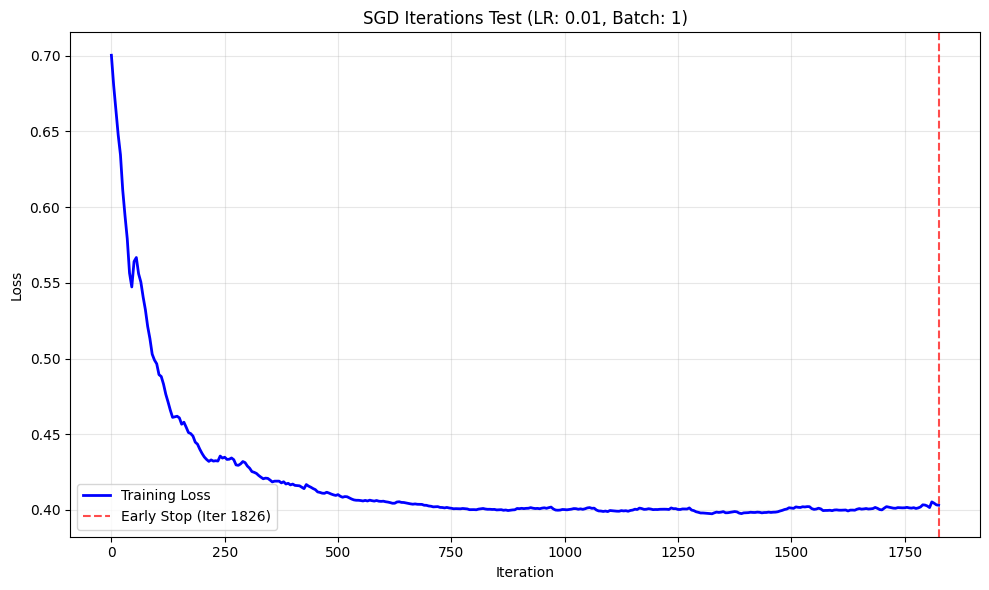

In [12]:
# Test the plotting functionality
test_optimizer.plot_loss_curve("SGD Iterations Test")

## AGD fixed learning rate

In [26]:
class AGDOptimizer:
    """
    Accelerated Gradient Descent (Nesterov's method) optimizer with early stopping and logging capabilities.
    
    Features:
    - Fixed learning rate with momentum acceleration
    - Nesterov momentum for improved convergence
    - Early stopping based on loss improvement threshold
    - Configurable logging intervals
    - Loss and momentum history tracking
    - Support for weighted loss computation
    """
    
    def __init__(self, learning_rate=0.01, momentum=0.9, max_epochs=MAX_EPOCHS, early_stop_patience=50, 
                 early_stop_threshold=EARLY_STOP_THRESHOLD, log_interval=10, verbose=True):
        """
        Initialize AGD optimizer.
        
        Args:
            learning_rate (float): Fixed learning rate for gradient descent
            momentum (float): Momentum coefficient (0 <= momentum < 1)
            max_epochs (int): Maximum number of training epochs
            early_stop_patience (int): Number of epochs to wait for improvement before stopping
            early_stop_threshold (float): Minimum improvement threshold for early stopping
            log_interval (int): Log metrics every n epochs
            verbose (bool): Whether to print training progress
        """
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.log_interval = log_interval
        self.verbose = verbose
        
        # Training history
        self.loss_history = []
        self.epoch_history = []
        self.stopped_early = False
        self.final_epoch = 0
        
        # Momentum variables
        self.velocity_w = None
        self.velocity_b = None
        
    def optimize(self, model, X_train, y_train, X_val=None, y_val=None,
                weights_train=None, weights_val=None):
        """
        Optimize model parameters using AGD with Nesterov momentum.
        
        Args:
            model: Model object with _compute_loss and _compute_gradient methods
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)
            weights_train: Training sample weights (optional)
            weights_val: Validation sample weights (optional)
            
        Returns:
            dict: Training history and statistics
        """
        # Initialize weights if not already done
        if model.weights is None:
            model.weights = np.random.normal(0, 0.01, X_train.shape[1])
            model.bias = 0.0
            
        # Initialize momentum variables
        self.velocity_w = np.zeros_like(model.weights)
        self.velocity_b = 0.0
            
        # Track best loss for early stopping
        best_loss = float('inf')
        patience_counter = 0
        
        if self.verbose:
            print(f"Starting AGD training with learning rate: {self.learning_rate}, momentum: {self.momentum}")
            print(f"Early stopping: patience={self.early_stop_patience}, threshold={self.early_stop_threshold}")
            if weights_train is not None:
                print(f"Using weighted loss with training weights shape: {weights_train.shape}")
            print("-" * 60)
            
        start_time = time.time()
        
        for epoch in range(self.max_epochs):
            # Nesterov momentum: compute gradients at the lookahead position
            # Store current parameters
            current_weights = model.weights.copy()
            current_bias = model.bias
            
            # Move to lookahead position
            model.weights = current_weights + self.momentum * self.velocity_w
            model.bias = current_bias + self.momentum * self.velocity_b
            
            # Compute loss at current position (before update) for monitoring
            model.weights = current_weights
            model.bias = current_bias
            train_loss = model._compute_loss(X_train, y_train, weights_train)
            
            # Compute gradients at lookahead position (weighted if weights provided)
            model.weights = current_weights + self.momentum * self.velocity_w
            model.bias = current_bias + self.momentum * self.velocity_b
            dw, db = model._compute_gradient(X_train, y_train, weights_train)
            
            # Update velocity
            self.velocity_w = self.momentum * self.velocity_w - self.learning_rate * dw
            self.velocity_b = self.momentum * self.velocity_b - self.learning_rate * db
            
            # Update parameters
            model.weights = current_weights + self.velocity_w
            model.bias = current_bias + self.velocity_b
            
            # Store history
            self.loss_history.append(train_loss)
            self.epoch_history.append(epoch)
            
            # Check for early stopping
            if train_loss < best_loss - self.early_stop_threshold:
                best_loss = train_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            # Log progress
            if (epoch + 1) % self.log_interval == 0 and self.verbose:
                val_loss_str = ""
                if X_val is not None and y_val is not None:
                    val_loss = model._compute_loss(X_val, y_val, weights_val)
                    val_loss_str = f", Val Loss: {val_loss:.6f}"
                    
                elapsed_time = time.time() - start_time
                print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss:.6f}{val_loss_str} | "
                      f"LR: {self.learning_rate:.4f} | Momentum: {self.momentum:.3f} | "
                      f"Patience: {patience_counter:2d}/{self.early_stop_patience} | "
                      f"Time: {elapsed_time:.2f}s")
                
            # Early stopping check
            if patience_counter >= self.early_stop_patience:
                self.stopped_early = True
                self.final_epoch = epoch + 1
                if self.verbose:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    print(f"No improvement in loss for {self.early_stop_patience} epochs "
                          f"(threshold: {self.early_stop_threshold})")
                break
                
        if not self.stopped_early:
            self.final_epoch = self.max_epochs
            if self.verbose:
                print(f"\nTraining completed after {self.max_epochs} epochs")
                
        training_time = time.time() - start_time
        final_loss = self.loss_history[-1]
        
        if self.verbose:
            print(f"Final loss: {final_loss:.6f}")
            print(f"Total training time: {training_time:.2f}s")
            print(f"Average time per epoch: {training_time/self.final_epoch:.4f}s")
            
        return {
            'loss_history': self.loss_history.copy(),
            'epoch_history': self.epoch_history.copy(),
            'final_loss': final_loss,
            'final_epoch': self.final_epoch,
            'stopped_early': self.stopped_early,
            'training_time': training_time,
            'learning_rate': self.learning_rate,
            'momentum': self.momentum
        }
    
    def plot_loss_curve(self, title="AGD Loss Curve"):
        """Plot the loss curve from training history."""
        if not self.loss_history:
            print("No training history available. Run optimize() first.")
            return
            
        plt.figure(figsize=(10, 6))
        plt.plot(self.epoch_history, self.loss_history, 'b-', linewidth=2, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{title} (LR: {self.learning_rate}, Momentum: {self.momentum})')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        if self.stopped_early:
            plt.axvline(x=self.final_epoch-1, color='r', linestyle='--', alpha=0.7, 
                       label=f'Early Stop (Epoch {self.final_epoch})')
            plt.legend()
            
        plt.tight_layout()
        plt.show()

## AGD backtracking line search

In [15]:
class AGDBacktrackingOptimizer:
    """
    Accelerated Gradient Descent with Backtracking Line Search.
    
    Features:
    - Nesterov momentum acceleration
    - Adaptive step size using Armijo line search condition
    - Backtracking algorithm with configurable parameters
    - Early stopping based on loss improvement threshold
    - Configurable logging intervals
    - Step size and momentum history tracking
    - Support for weighted loss computation
    """
    
    def __init__(self, initial_learning_rate=1.0, momentum=0.9, c1=1e-4, rho=0.5, 
                 max_epochs=MAX_EPOCHS, early_stop_patience=50, early_stop_threshold=EARLY_STOP_THRESHOLD, 
                 log_interval=10, max_backtrack_iter=20, verbose=True):
        """
        Initialize AGD Backtracking optimizer.
        
        Args:
            initial_learning_rate (float): Initial step size for backtracking
            momentum (float): Momentum coefficient (0 <= momentum < 1)
            c1 (float): Armijo condition parameter (0 < c1 < 1)
            rho (float): Step size reduction factor (0 < rho < 1)
            max_epochs (int): Maximum number of training epochs
            early_stop_patience (int): Number of epochs to wait for improvement before stopping
            early_stop_threshold (float): Minimum improvement threshold for early stopping
            log_interval (int): Log metrics every n epochs
            max_backtrack_iter (int): Maximum backtracking iterations per epoch
            verbose (bool): Whether to print training progress
        """
        self.initial_learning_rate = initial_learning_rate
        self.momentum = momentum
        self.c1 = c1  # Armijo parameter
        self.rho = rho  # Step reduction factor
        self.max_epochs = max_epochs
        self.early_stop_patience = early_stop_patience
        self.early_stop_threshold = early_stop_threshold
        self.log_interval = log_interval
        self.max_backtrack_iter = max_backtrack_iter
        self.verbose = verbose
        
        # Training history
        self.loss_history = []
        self.epoch_history = []
        self.step_size_history = []
        self.backtrack_iterations_history = []
        self.stopped_early = False
        self.final_epoch = 0
        
        # Momentum variables
        self.velocity_w = None
        self.velocity_b = None
        
    def _armijo_condition(self, f_current, f_new, grad_dot_direction, step_size):
        """
        Check Armijo sufficient decrease condition.
        
        Args:
            f_current: Current function value
            f_new: New function value after step
            grad_dot_direction: Gradient dot product with search direction
            step_size: Current step size
            
        Returns:
            bool: True if Armijo condition is satisfied
        """
        return f_new <= f_current + self.c1 * step_size * grad_dot_direction
    
    def _backtracking_line_search_agd(self, model, X, y, current_weights, current_bias,
                                      velocity_w, velocity_b, dw, db, current_loss, sample_weights=None):
        """
        Perform backtracking line search for AGD to find suitable step size.
        
        Args:
            model: Model object
            X: Input features
            y: Target values
            current_weights: Current weight parameters
            current_bias: Current bias parameter
            velocity_w: Current weight velocity
            velocity_b: Current bias velocity
            dw: Weight gradients
            db: Bias gradient
            current_loss: Current loss value
            sample_weights: Sample weights for weighted loss computation
            
        Returns:
            tuple: (step_size, backtrack_iterations)
        """
        step_size = self.initial_learning_rate
        
        # Compute gradient norm squared (for descent direction)
        grad_norm_sq = np.sum(dw**2) + db**2
        
        # Search direction is negative gradient (velocity update direction)
        direction_dot_grad = -grad_norm_sq
        
        backtrack_iter = 0
        
        for i in range(self.max_backtrack_iter):
            # Try step with current step size
            # Update velocity
            new_velocity_w = self.momentum * velocity_w - step_size * dw
            new_velocity_b = self.momentum * velocity_b - step_size * db
            
            # Update parameters
            new_weights = current_weights + new_velocity_w
            new_bias = current_bias + new_velocity_b
            
            # Temporarily update model parameters to compute new loss
            old_weights = model.weights.copy()
            old_bias = model.bias
            
            model.weights = new_weights
            model.bias = new_bias
            
            new_loss = model._compute_loss(X, y, sample_weights)
            
            # Restore original parameters
            model.weights = old_weights
            model.bias = old_bias
            
            # Check Armijo condition
            if self._armijo_condition(current_loss, new_loss, direction_dot_grad, step_size):
                break
                
            # Reduce step size
            step_size *= self.rho
            backtrack_iter += 1
            
        return step_size, backtrack_iter
        
    def optimize(self, model, X_train, y_train, X_val=None, y_val=None,
                weights_train=None, weights_val=None):
        """
        Optimize model parameters using AGD with backtracking line search.
        
        Args:
            model: Model object with _compute_loss and _compute_gradient methods
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional)
            y_val: Validation targets (optional)
            weights_train: Training sample weights (optional)
            weights_val: Validation sample weights (optional)
            
        Returns:
            dict: Training history and statistics
        """
        # Initialize weights if not already done
        if model.weights is None:
            model.weights = np.random.normal(0, 0.01, X_train.shape[1])
            model.bias = 0.0
            
        # Initialize momentum variables
        self.velocity_w = np.zeros_like(model.weights)
        self.velocity_b = 0.0
            
        # Track best loss for early stopping
        best_loss = float('inf')
        patience_counter = 0
        
        if self.verbose:
            print(f"Starting AGD with Backtracking Line Search")
            print(f"Initial step size: {self.initial_learning_rate}, momentum: {self.momentum}")
            print(f"c1: {self.c1}, rho: {self.rho}")
            print(f"Early stopping: patience={self.early_stop_patience}, threshold={self.early_stop_threshold}")
            if weights_train is not None:
                print(f"Using weighted loss with training weights shape: {weights_train.shape}")
            print("-" * 80)
            
        start_time = time.time()
        
        for epoch in range(self.max_epochs):
            # Nesterov momentum: compute gradients at the lookahead position
            # Store current parameters
            current_weights = model.weights.copy()
            current_bias = model.bias
            
            # Move to lookahead position for gradient computation
            lookahead_weights = current_weights + self.momentum * self.velocity_w
            lookahead_bias = current_bias + self.momentum * self.velocity_b
            
            # Compute loss at current position (before update) for monitoring
            train_loss = model._compute_loss(X_train, y_train, weights_train)
            
            # Compute gradients at lookahead position (weighted if weights provided)
            model.weights = lookahead_weights
            model.bias = lookahead_bias
            dw, db = model._compute_gradient(X_train, y_train, weights_train)
            
            # Restore current position
            model.weights = current_weights
            model.bias = current_bias
            
            # Perform backtracking line search
            step_size, backtrack_iter = self._backtracking_line_search_agd(
                model, X_train, y_train, current_weights, current_bias,
                self.velocity_w, self.velocity_b, dw, db, train_loss, weights_train
            )
            
            # Update velocity with found step size
            self.velocity_w = self.momentum * self.velocity_w - step_size * dw
            self.velocity_b = self.momentum * self.velocity_b - step_size * db
            
            # Update parameters
            model.weights = current_weights + self.velocity_w
            model.bias = current_bias + self.velocity_b
            
            # Store history
            self.loss_history.append(train_loss)
            self.epoch_history.append(epoch)
            self.step_size_history.append(step_size)
            self.backtrack_iterations_history.append(backtrack_iter)
            
            # Check for early stopping
            if train_loss < best_loss - self.early_stop_threshold:
                best_loss = train_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            # Log progress
            if (epoch + 1) % self.log_interval == 0 and self.verbose:
                val_loss_str = ""
                if X_val is not None and y_val is not None:
                    val_loss = model._compute_loss(X_val, y_val, weights_val)
                    val_loss_str = f", Val Loss: {val_loss:.6f}"
                    
                elapsed_time = time.time() - start_time
                avg_step_size = np.mean(self.step_size_history[-self.log_interval:])
                avg_backtrack = np.mean(self.backtrack_iterations_history[-self.log_interval:])
                
                print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss:.6f}{val_loss_str} | "
                      f"Step Size: {step_size:.6f} | Avg Step: {avg_step_size:.6f} | "
                      f"Momentum: {self.momentum:.3f} | Backtrack: {backtrack_iter:2d} | "
                      f"Avg BT: {avg_backtrack:.1f} | Patience: {patience_counter:2d}/{self.early_stop_patience} | "
                      f"Time: {elapsed_time:.2f}s")
                
            # Early stopping check
            if patience_counter >= self.early_stop_patience:
                self.stopped_early = True
                self.final_epoch = epoch + 1
                if self.verbose:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    print(f"No improvement in loss for {self.early_stop_patience} epochs "
                          f"(threshold: {self.early_stop_threshold})")
                break
                
        if not self.stopped_early:
            self.final_epoch = self.max_epochs
            if self.verbose:
                print(f"\nTraining completed after {self.max_epochs} epochs")
                
        training_time = time.time() - start_time
        final_loss = self.loss_history[-1]
        
        if self.verbose:
            print(f"Final loss: {final_loss:.6f}")
            print(f"Total training time: {training_time:.2f}s")
            print(f"Average time per epoch: {training_time/self.final_epoch:.4f}s")
            print(f"Average step size: {np.mean(self.step_size_history):.6f}")
            print(f"Final step size: {self.step_size_history[-1]:.6f}")
            print(f"Average backtrack iterations: {np.mean(self.backtrack_iterations_history):.2f}")
            
        return {
            'loss_history': self.loss_history.copy(),
            'epoch_history': self.epoch_history.copy(),
            'step_size_history': self.step_size_history.copy(),
            'backtrack_iterations_history': self.backtrack_iterations_history.copy(),
            'final_loss': final_loss,
            'final_epoch': self.final_epoch,
            'stopped_early': self.stopped_early,
            'training_time': training_time,
            'initial_learning_rate': self.initial_learning_rate,
            'momentum': self.momentum,
            'avg_step_size': np.mean(self.step_size_history),
            'final_step_size': self.step_size_history[-1],
            'avg_backtrack_iterations': np.mean(self.backtrack_iterations_history)
        }
    
    def plot_training_curves(self, title="AGD Backtracking Training Curves"):
        """Plot loss curve and step size evolution."""
        if not self.loss_history:
            print("No training history available. Run optimize() first.")
            return
            
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
        
        # Plot 1: Loss curve
        ax1.plot(self.epoch_history, self.loss_history, 'b-', linewidth=2, label='Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'{title} - Loss Evolution (Momentum: {self.momentum})')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        if self.stopped_early:
            ax1.axvline(x=self.final_epoch-1, color='r', linestyle='--', alpha=0.7, 
                       label=f'Early Stop (Epoch {self.final_epoch})')
            ax1.legend()
        
        # Plot 2: Step size evolution
        ax2.plot(self.epoch_history, self.step_size_history, 'g-', linewidth=2, label='Step Size')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Step Size')
        ax2.set_title('Step Size Evolution')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.set_yscale('log')  # Log scale for better visualization
        
        # Plot 3: Backtrack iterations
        ax3.plot(self.epoch_history, self.backtrack_iterations_history, 'r-', linewidth=2, 
                label='Backtrack Iterations')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Backtrack Iterations')
        ax3.set_title('Backtracking Iterations per Epoch')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
            
        plt.tight_layout()
        plt.show()

# Train

## SGD fixed learning rate

In [12]:
weighted_model = WeightedLogisticRegression()
configs = [
    {"learning_rate": 0.01},
    {"learning_rate": 0.05},
    {"learning_rate": 0.1},
]
for config in configs:
    weighted_optimizer = SGDOptimizer(
        max_epochs=MAX_EPOCHS,
        early_stop_threshold=EARLY_STOP_THRESHOLD,
        log_interval=20,
        verbose=True,
        learning_rate=config["learning_rate"],
    )
    weighted_result = weighted_optimizer.optimize(
        weighted_model, X_train_scaled, y_train, weights_train=weights_train
    )

    print(f"Weighted final loss:   {weighted_result['final_loss']:.6f}")
    print(f"Weighted final epoch:   {weighted_result['final_epoch']}")

Starting SGD training with learning rate: 0.01
Early stopping: patience=50, threshold=1e-06
Using weighted loss with training weights shape: (438744,)
------------------------------------------------------------
Epoch   20 | Train Loss: 0.597363 | LR: 0.0100 | Patience:  0/50 | Time: 0.54s
Epoch   40 | Train Loss: 0.541136 | LR: 0.0100 | Patience:  0/50 | Time: 1.05s
Epoch   60 | Train Loss: 0.508028 | LR: 0.0100 | Patience:  0/50 | Time: 1.56s
Epoch   80 | Train Loss: 0.486606 | LR: 0.0100 | Patience:  0/50 | Time: 2.08s
Epoch  100 | Train Loss: 0.471761 | LR: 0.0100 | Patience:  0/50 | Time: 2.61s
Epoch  120 | Train Loss: 0.460933 | LR: 0.0100 | Patience:  0/50 | Time: 3.11s
Epoch  140 | Train Loss: 0.452719 | LR: 0.0100 | Patience:  0/50 | Time: 3.65s
Epoch  160 | Train Loss: 0.446285 | LR: 0.0100 | Patience:  0/50 | Time: 4.20s
Epoch  180 | Train Loss: 0.441114 | LR: 0.0100 | Patience:  0/50 | Time: 4.73s
Epoch  200 | Train Loss: 0.436865 | LR: 0.0100 | Patience:  0/50 | Time: 5.24

## SGD backtracking

In [14]:
sgd_bt_model = WeightedLogisticRegression()
configs = [
    {"init_learning_rate": 0.1},
    {"init_learning_rate": 1.0},
    {"init_learning_rate": 5.0},
]
for config in configs:
    sgd_bt_opt = SGDBacktrackingOptimizer(
        initial_learning_rate=config["init_learning_rate"],
        log_interval=50,
        verbose=True,
        max_epochs=MAX_EPOCHS,
        early_stop_threshold=EARLY_STOP_THRESHOLD,
    )
    weighted_result = sgd_bt_opt.optimize(
        sgd_bt_model,
        X_train_scaled,
        y_train,
        X_val_scaled,
        y_val,
        weights_train,
        weights_val,
    )

Starting SGD with Backtracking Line Search
Initial step size: 0.1, c1: 0.0001, rho: 0.5
Early stopping: patience=50, threshold=1e-06
Using weighted loss with training weights shape: (438744,)
--------------------------------------------------------------------------------
Epoch   50 | Train Loss: 0.411206, Val Loss: 0.410006 | Step Size: 0.100000 | Avg Step: 0.100000 | Backtrack:  0 | Avg BT: 0.0 | Patience:  0/50 | Time: 2.15s
Epoch  100 | Train Loss: 0.400001, Val Loss: 0.399086 | Step Size: 0.100000 | Avg Step: 0.100000 | Backtrack:  0 | Avg BT: 0.0 | Patience:  0/50 | Time: 4.34s
Epoch  150 | Train Loss: 0.396421, Val Loss: 0.395591 | Step Size: 0.100000 | Avg Step: 0.100000 | Backtrack:  0 | Avg BT: 0.0 | Patience:  0/50 | Time: 6.59s
Epoch  200 | Train Loss: 0.395093, Val Loss: 0.394292 | Step Size: 0.100000 | Avg Step: 0.100000 | Backtrack:  0 | Avg BT: 0.0 | Patience:  0/50 | Time: 8.67s
Epoch  250 | Train Loss: 0.394557, Val Loss: 0.393768 | Step Size: 0.100000 | Avg Step: 0.1

## AGD fixed learning rate

In [ ]:
agd_weighted_model = WeightedLogisticRegression()
configs = [
    {"learning_rate": 0.001, "momentum": 0.9},
    {"learning_rate": 0.005, "momentum": 0.9},
    {"learning_rate": 0.01, "momentum": 0.9},
    {"learning_rate": 0.1, "momentum": 0.9},
]
for config in configs:
    agd_weighted_optimizer = AGDOptimizer(
        max_epochs=MAX_EPOCHS,
        early_stop_threshold=EARLY_STOP_THRESHOLD,
        log_interval=20,
        verbose=True,
        learning_rate=config["learning_rate"],
        momentum=config["momentum"],
    )
    agd_weighted_result = agd_weighted_optimizer.optimize(
        agd_weighted_model,
        X_train=X_train_scaled,
        y_train=y_train,
        weights_train=weights_train,
    )
    print(f"AGD Weighted final loss:   {agd_weighted_result['final_loss']:.6f}")
    print("=" * 80)

## AGD backtracking line search

In [17]:
agd_bt_weighted_model = WeightedLogisticRegression()
configs = [
    {"init_learning_rate": 0.1, "momentum": 0.9},
    {"init_learning_rate": 1.0, "momentum": 0.9},
    {"init_learning_rate": 5.0, "momentum": 0.9},
]
for config in configs:
    agd_bt_weighted_optimizer = AGDBacktrackingOptimizer(
        initial_learning_rate=config["init_learning_rate"],
        momentum=config["momentum"],
        log_interval=20,
        verbose=True,
    )
    agd_bt_weighted_result = agd_bt_weighted_optimizer.optimize(
        agd_bt_weighted_model,
        X_train_scaled,
        y_train,
        weights_train=weights_train,
    )

Starting AGD with Backtracking Line Search
Initial step size: 0.1, momentum: 0.9
c1: 0.0001, rho: 0.5
Early stopping: patience=50, threshold=1e-06
Using weighted loss with training weights shape: (438744,)
--------------------------------------------------------------------------------
Epoch   20 | Train Loss: 0.465012 | Step Size: 0.000000 | Avg Step: 0.040000 | Momentum: 0.900 | Backtrack: 20 | Avg BT: 12.0 | Patience: 11/50 | Time: 4.78s
Epoch   40 | Train Loss: 0.400968 | Step Size: 0.000000 | Avg Step: 0.075000 | Momentum: 0.900 | Backtrack: 20 | Avg BT: 5.0 | Patience:  3/50 | Time: 7.30s
Epoch   60 | Train Loss: 0.395129 | Step Size: 0.000000 | Avg Step: 0.050000 | Momentum: 0.900 | Backtrack: 20 | Avg BT: 10.0 | Patience:  2/50 | Time: 11.26s
Epoch   80 | Train Loss: 0.395985 | Step Size: 0.100000 | Avg Step: 0.045000 | Momentum: 0.900 | Backtrack:  0 | Avg BT: 11.0 | Patience: 22/50 | Time: 15.57s
Epoch  100 | Train Loss: 0.396662 | Step Size: 0.100000 | Avg Step: 0.040000 | M

## SGD iterations (mini-batch)

In [13]:
sgd_iter_weighted_model = WeightedLogisticRegression()
configs = [
    {"learning_rate": 0.01, "batch_size": 32},
    {"learning_rate": 0.05, "batch_size": 32},
    {"learning_rate": 0.01, "batch_size": 128},
    {"learning_rate": 0.05, "batch_size": 128},
]

for config in configs:
    print(f"\nTesting SGD Iterations with LR: {config['learning_rate']}, Batch Size: {config['batch_size']}")
    print("=" * 80)
    
    sgd_iter_weighted_optimizer = SGDIterationsOptimizer(
        learning_rate=config["learning_rate"],
        batch_size=config["batch_size"],
        max_iterations=50000,  # Equivalent to roughly 50-100 epochs depending on batch size
        early_stop_patience=200,
        early_stop_threshold=EARLY_STOP_THRESHOLD,
        log_interval=20,
        verbose=True,
    )
    
    sgd_iter_weighted_result = sgd_iter_weighted_optimizer.optimize(
        sgd_iter_weighted_model,
        X_train_scaled,
        y_train,
        X_val_scaled,
        y_val,
        weights_train=weights_train,
        weights_val=weights_val,
    )
    
    print(f"Final loss: {sgd_iter_weighted_result['final_loss']:.6f}")
    print(f"Total iterations: {sgd_iter_weighted_result['final_iteration']}")
    print(f"Approximate epochs: {sgd_iter_weighted_result['approximate_epochs']:.2f}")
    print("=" * 80)


Testing SGD Iterations with LR: 0.01, Batch Size: 32
Starting SGD Iterations training
Learning rate: 0.01, Batch size: 32
Max iterations: 50000
Early stopping: patience=200, threshold=1e-06
Using weighted loss with training weights shape: (438744,)
Initial full dataset loss: 0.689627
----------------------------------------------------------------------
Iter    20 | Train Loss: 0.594208, Val Loss: 0.594168 | LR: 0.0100 | Batch:  32 | Patience:   0/200 | Rate: 86.4 iter/s | Time: 0.23s
Iter    40 | Train Loss: 0.538080, Val Loss: 0.537966 | LR: 0.0100 | Batch:  32 | Patience:   0/200 | Rate: 91.6 iter/s | Time: 0.44s
Iter    60 | Train Loss: 0.506395, Val Loss: 0.506175 | LR: 0.0100 | Batch:  32 | Patience:   0/200 | Rate: 83.9 iter/s | Time: 0.72s
Iter    80 | Train Loss: 0.485677, Val Loss: 0.485346 | LR: 0.0100 | Batch:  32 | Patience:   0/200 | Rate: 82.3 iter/s | Time: 0.97s
Iter   100 | Train Loss: 0.471340, Val Loss: 0.470923 | LR: 0.0100 | Batch:  32 | Patience:   0/200 | Rate:

# Visualization

In [18]:
images_dir = OUTPUT_DIR / "images"
print(f"Images will be saved to: {images_dir}")

Images will be saved to: ../data/output/images


## SGD fixed learning rate

Starting SGD training with learning rate: 0.01
Early stopping: patience=50, threshold=1e-06
Using weighted loss with training weights shape: (438744,)
------------------------------------------------------------
Epoch   20 | Train Loss: 0.591072 | LR: 0.0100 | Patience:  0/50 | Time: 0.60s
Epoch   20 | Train Loss: 0.591072 | LR: 0.0100 | Patience:  0/50 | Time: 0.60s
Epoch   40 | Train Loss: 0.538788 | LR: 0.0100 | Patience:  0/50 | Time: 1.21s
Epoch   40 | Train Loss: 0.538788 | LR: 0.0100 | Patience:  0/50 | Time: 1.21s
Epoch   60 | Train Loss: 0.507421 | LR: 0.0100 | Patience:  0/50 | Time: 1.79s
Epoch   60 | Train Loss: 0.507421 | LR: 0.0100 | Patience:  0/50 | Time: 1.79s
Epoch   80 | Train Loss: 0.486837 | LR: 0.0100 | Patience:  0/50 | Time: 2.37s
Epoch   80 | Train Loss: 0.486837 | LR: 0.0100 | Patience:  0/50 | Time: 2.37s
Epoch  100 | Train Loss: 0.472418 | LR: 0.0100 | Patience:  0/50 | Time: 3.02s
Epoch  100 | Train Loss: 0.472418 | LR: 0.0100 | Patience:  0/50 | Time: 3.02

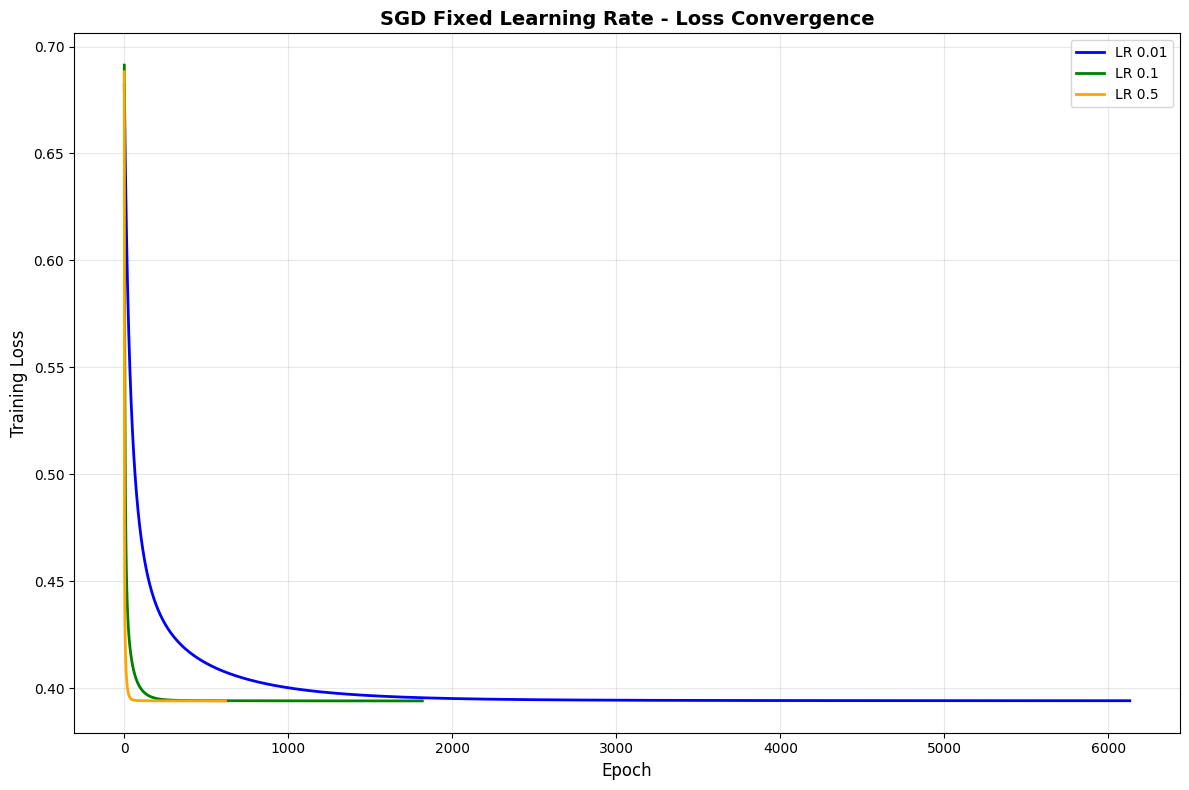

✅ SGD Fixed Learning Rate comparison saved!


In [22]:
# SGD Fixed Learning Rate - Loss Convergence Comparison
plt.figure(figsize=(12, 8))

sgd_configs = [
    {"learning_rate": 0.01, "color": "blue", "label": "LR 0.01"},
    {"learning_rate": 0.10, "color": "green", "label": "LR 0.1"},
    {"learning_rate": 0.5, "color": "orange", "label": "LR 0.5"}, 
]

for config in sgd_configs:
    model = WeightedLogisticRegression()
    optimizer = SGDOptimizer(
        learning_rate=config["learning_rate"],
        log_interval=20,
        verbose=True,
    )
    
    result = optimizer.optimize(
        model, X_train_scaled, y_train, 
        weights_train=weights_train
    )
    
    plt.plot(result['epoch_history'], result['loss_history'], 
             color=config["color"], linewidth=2, label=config["label"])

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('SGD Fixed Learning Rate - Loss Convergence', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig(images_dir / "sgd_fixed_lr_convergence.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ SGD Fixed Learning Rate comparison saved!")

## SGD backtracking

Starting SGD with Backtracking Line Search
Initial step size: 0.1, c1: 0.0001, rho: 0.5
Early stopping: patience=50, threshold=1e-06
Using weighted loss with training weights shape: (438744,)
--------------------------------------------------------------------------------
Epoch   20 | Train Loss: 0.437816 | Step Size: 0.100000 | Avg Step: 0.100000 | Backtrack:  0 | Avg BT: 0.0 | Patience:  0/50 | Time: 0.95s
Epoch   20 | Train Loss: 0.437816 | Step Size: 0.100000 | Avg Step: 0.100000 | Backtrack:  0 | Avg BT: 0.0 | Patience:  0/50 | Time: 0.95s
Epoch   40 | Train Loss: 0.416375 | Step Size: 0.100000 | Avg Step: 0.100000 | Backtrack:  0 | Avg BT: 0.0 | Patience:  0/50 | Time: 1.82s
Epoch   40 | Train Loss: 0.416375 | Step Size: 0.100000 | Avg Step: 0.100000 | Backtrack:  0 | Avg BT: 0.0 | Patience:  0/50 | Time: 1.82s
Epoch   60 | Train Loss: 0.407811 | Step Size: 0.100000 | Avg Step: 0.100000 | Backtrack:  0 | Avg BT: 0.0 | Patience:  0/50 | Time: 2.65s
Epoch   60 | Train Loss: 0.40781

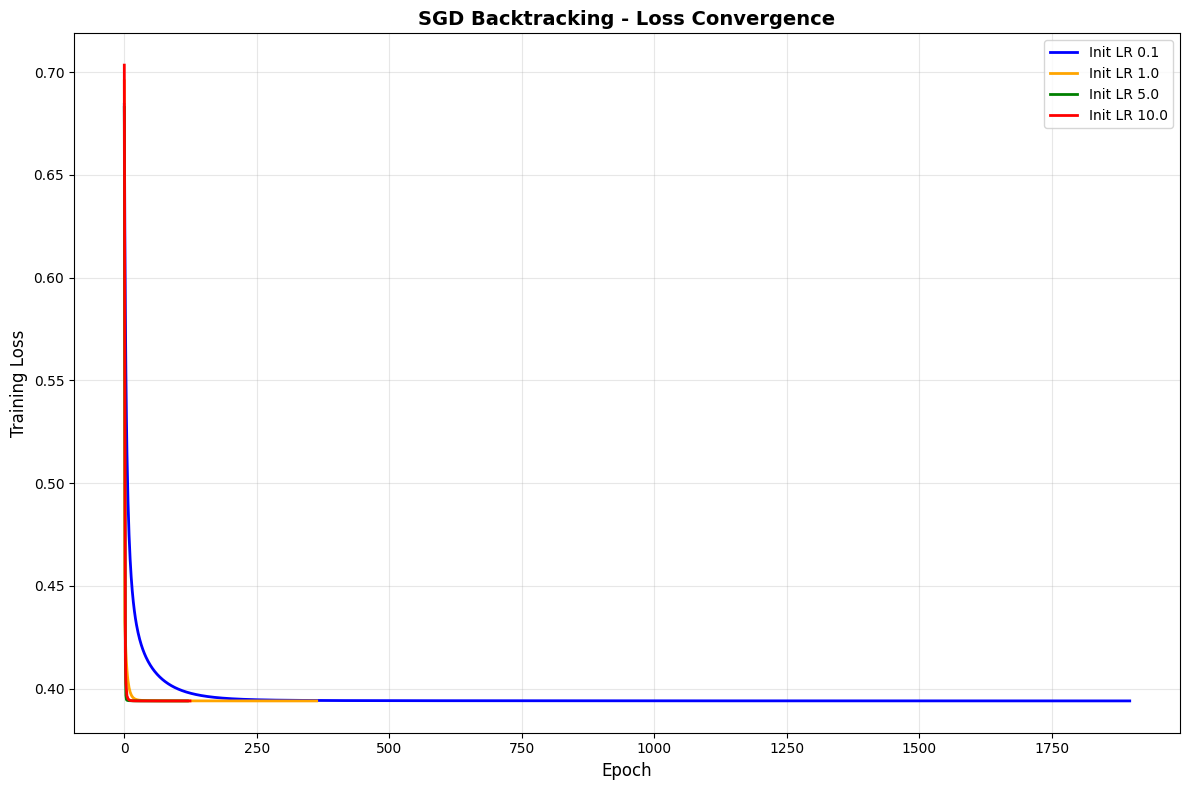

✅ SGD Backtracking comparison saved!


In [23]:
# SGD Backtracking - Loss Convergence Comparison  
plt.figure(figsize=(12, 8))

sgd_bt_configs = [
    {"init_lr": 0.1, "color": "blue", "label": "Init LR 0.1"},
    {"init_lr": 1.0, "color": "orange", "label": "Init LR 1.0"},
    {"init_lr": 5.0, "color": "green", "label": "Init LR 5.0"},
    {"init_lr": 10.0, "color": "red", "label": "Init LR 10.0"},
]

for config in sgd_bt_configs:
    model = WeightedLogisticRegression()
    optimizer = SGDBacktrackingOptimizer(
        initial_learning_rate=config["init_lr"],
        log_interval=20,
        verbose=True,
    )
    
    result = optimizer.optimize(
        model, X_train_scaled, y_train,
        weights_train=weights_train
    )
    
    plt.plot(result['epoch_history'], result['loss_history'], 
             color=config["color"], linewidth=2, label=config["label"])

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('SGD Backtracking - Loss Convergence', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(images_dir / "sgd_backtracking_convergence.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ SGD Backtracking comparison saved!")

## AGD fixed learning rate

Starting AGD training with learning rate: 0.01, momentum: 0.9
Early stopping: patience=50, threshold=1e-06
Using weighted loss with training weights shape: (438744,)
------------------------------------------------------------
Epoch   20 | Train Loss: 0.446318 | LR: 0.0100 | Momentum: 0.900 | Patience:  0/50 | Time: 0.63s
Epoch   20 | Train Loss: 0.446318 | LR: 0.0100 | Momentum: 0.900 | Patience:  0/50 | Time: 0.63s
Epoch   40 | Train Loss: 0.417985 | LR: 0.0100 | Momentum: 0.900 | Patience:  0/50 | Time: 1.17s
Epoch   40 | Train Loss: 0.417985 | LR: 0.0100 | Momentum: 0.900 | Patience:  0/50 | Time: 1.17s
Epoch   60 | Train Loss: 0.408830 | LR: 0.0100 | Momentum: 0.900 | Patience:  0/50 | Time: 1.71s
Epoch   60 | Train Loss: 0.408830 | LR: 0.0100 | Momentum: 0.900 | Patience:  0/50 | Time: 1.71s
Epoch   80 | Train Loss: 0.403193 | LR: 0.0100 | Momentum: 0.900 | Patience:  0/50 | Time: 2.26s
Epoch   80 | Train Loss: 0.403193 | LR: 0.0100 | Momentum: 0.900 | Patience:  0/50 | Time: 2.2

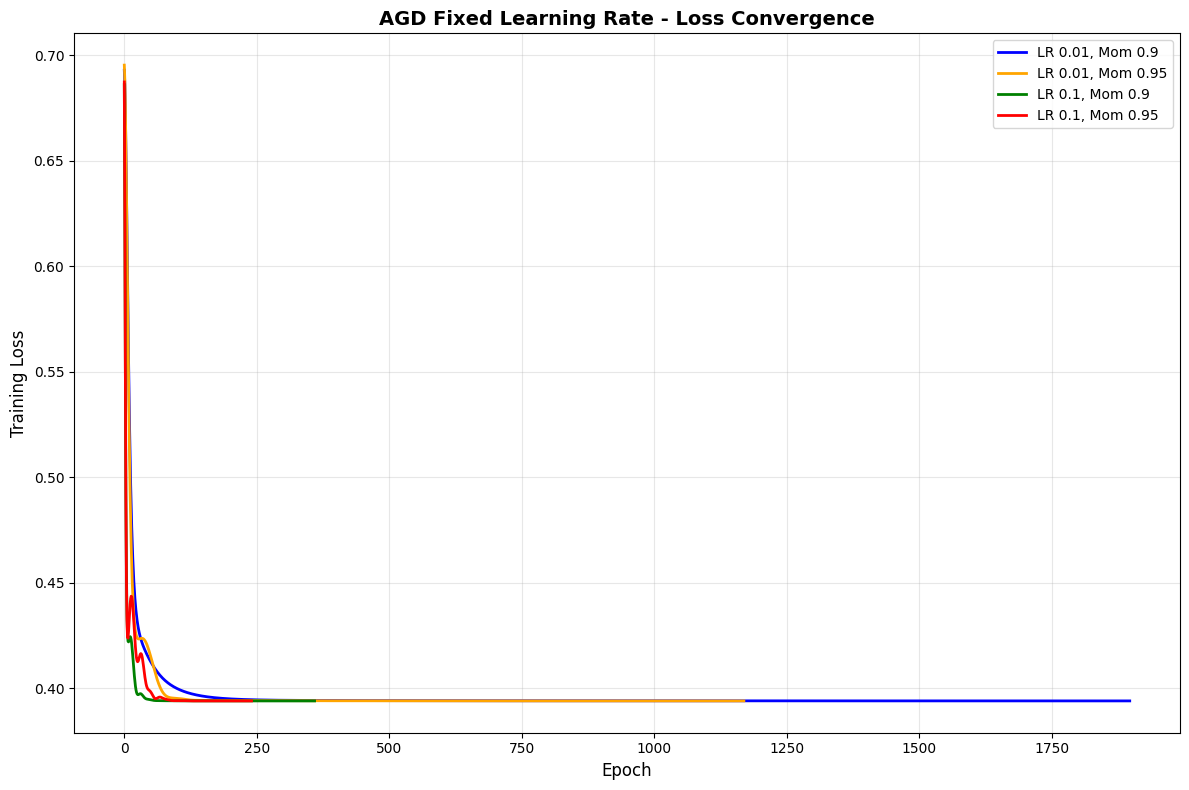

✅ AGD Fixed Learning Rate comparison saved!


In [27]:
# AGD Fixed Learning Rate - Loss Convergence Comparison
plt.figure(figsize=(12, 8))

agd_configs = [
    {"lr": 0.01, "momentum": 0.9, "color": "blue", "label": "LR 0.01, Mom 0.9"},
    {"lr": 0.01, "momentum": 0.95, "color": "orange", "label": "LR 0.01, Mom 0.95"},
    {"lr": 0.1, "momentum": 0.9, "color": "green", "label": "LR 0.1, Mom 0.9"},
    {"lr": 0.1, "momentum": 0.95, "color": "red", "label": "LR 0.1, Mom 0.95"},
]

for config in agd_configs:
    model = WeightedLogisticRegression()
    optimizer = AGDOptimizer(
        learning_rate=config["lr"],
        momentum=config["momentum"],
        log_interval=20,
        verbose=True,
    )
    
    result = optimizer.optimize(
        model, X_train_scaled, y_train,
        weights_train=weights_train
    )
    
    plt.plot(result['epoch_history'], result['loss_history'], 
             color=config["color"], linewidth=2, label=config["label"])

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('AGD Fixed Learning Rate - Loss Convergence', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(images_dir / "agd_fixed_lr_convergence.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ AGD Fixed Learning Rate comparison saved!")

## AGD backtracking

Starting AGD with Backtracking Line Search
Initial step size: 0.01, momentum: 0.9
c1: 0.0001, rho: 0.5
Early stopping: patience=50, threshold=1e-06
Using weighted loss with training weights shape: (438744,)
--------------------------------------------------------------------------------
Epoch   20 | Train Loss: 0.444398 | Step Size: 0.010000 | Avg Step: 0.010000 | Momentum: 0.900 | Backtrack:  0 | Avg BT: 0.0 | Patience:  0/50 | Time: 1.22s
Epoch   20 | Train Loss: 0.444398 | Step Size: 0.010000 | Avg Step: 0.010000 | Momentum: 0.900 | Backtrack:  0 | Avg BT: 0.0 | Patience:  0/50 | Time: 1.22s
Epoch   40 | Train Loss: 0.417034 | Step Size: 0.010000 | Avg Step: 0.010000 | Momentum: 0.900 | Backtrack:  0 | Avg BT: 0.0 | Patience:  0/50 | Time: 2.52s
Epoch   40 | Train Loss: 0.417034 | Step Size: 0.010000 | Avg Step: 0.010000 | Momentum: 0.900 | Backtrack:  0 | Avg BT: 0.0 | Patience:  0/50 | Time: 2.52s
Epoch   60 | Train Loss: 0.408205 | Step Size: 0.010000 | Avg Step: 0.010000 | Momen

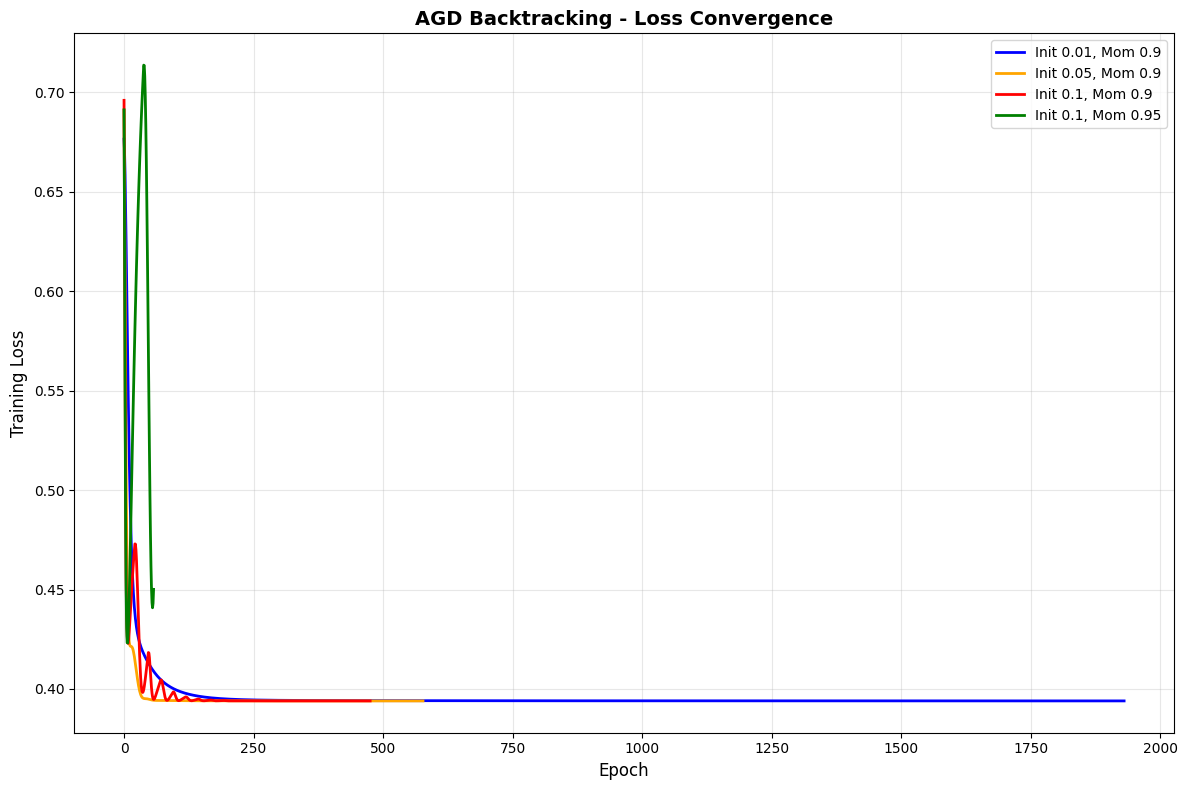

✅ AGD Backtracking comparison saved!


In [ ]:
# AGD Backtracking - Loss Convergence Comparison
plt.figure(figsize=(12, 8))

agd_bt_configs = [
    {"init_lr": 0.01, "momentum": 0.9, "color": "blue", "label": "Init 0.01, Mom 0.9"},
    {"init_lr": 0.05, "momentum": 0.9, "color": "orange", "label": "Init 0.05, Mom 0.9"},
    {"init_lr": 0.1, "momentum": 0.9, "color": "red", "label": "Init 0.1, Mom 0.9"},
    {"init_lr": 0.1, "momentum": 0.95, "color": "green", "label": "Init 0.1, Mom 0.95"},
]

for config in agd_bt_configs:
    model = WeightedLogisticRegression()
    optimizer = AGDBacktrackingOptimizer(
        initial_learning_rate=config["init_lr"],
        momentum=config["momentum"],
        log_interval=20,
        verbose=True
    )
    
    result = optimizer.optimize(
        model, X_train_scaled, y_train,
        weights_train=weights_train
    )
    
    plt.plot(result['epoch_history'], result['loss_history'], 
             color=config["color"], linewidth=2, label=config["label"])

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('AGD Backtracking - Loss Convergence', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(images_dir / "agd_backtracking_convergence.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ AGD Backtracking comparison saved!")

## SGD iterations (mini-batch)

Starting SGD Iterations training
Learning rate: 0.01, Batch size: 1
Max iterations: 100000
Early stopping: patience=500, threshold=1e-06
Using weighted loss with training weights shape: (438744,)
Initial full dataset loss: 0.684106
----------------------------------------------------------------------
Iter    20 | Train Loss: 0.600300 | LR: 0.0100 | Batch:   1 | Patience:   0/500 | Rate: 86.5 iter/s | Time: 0.23s
Iter    40 | Train Loss: 0.541488 | LR: 0.0100 | Batch:   1 | Patience:   0/500 | Rate: 95.2 iter/s | Time: 0.42s
Iter    60 | Train Loss: 0.514474 | LR: 0.0100 | Batch:   1 | Patience:   0/500 | Rate: 96.0 iter/s | Time: 0.62s
Iter    80 | Train Loss: 0.492335 | LR: 0.0100 | Batch:   1 | Patience:   0/500 | Rate: 95.8 iter/s | Time: 0.83s
Iter   100 | Train Loss: 0.479825 | LR: 0.0100 | Batch:   1 | Patience:   0/500 | Rate: 97.0 iter/s | Time: 1.03s
Iter   120 | Train Loss: 0.472780 | LR: 0.0100 | Batch:   1 | Patience:   1/500 | Rate: 97.8 iter/s | Time: 1.23s
Iter   140 | 

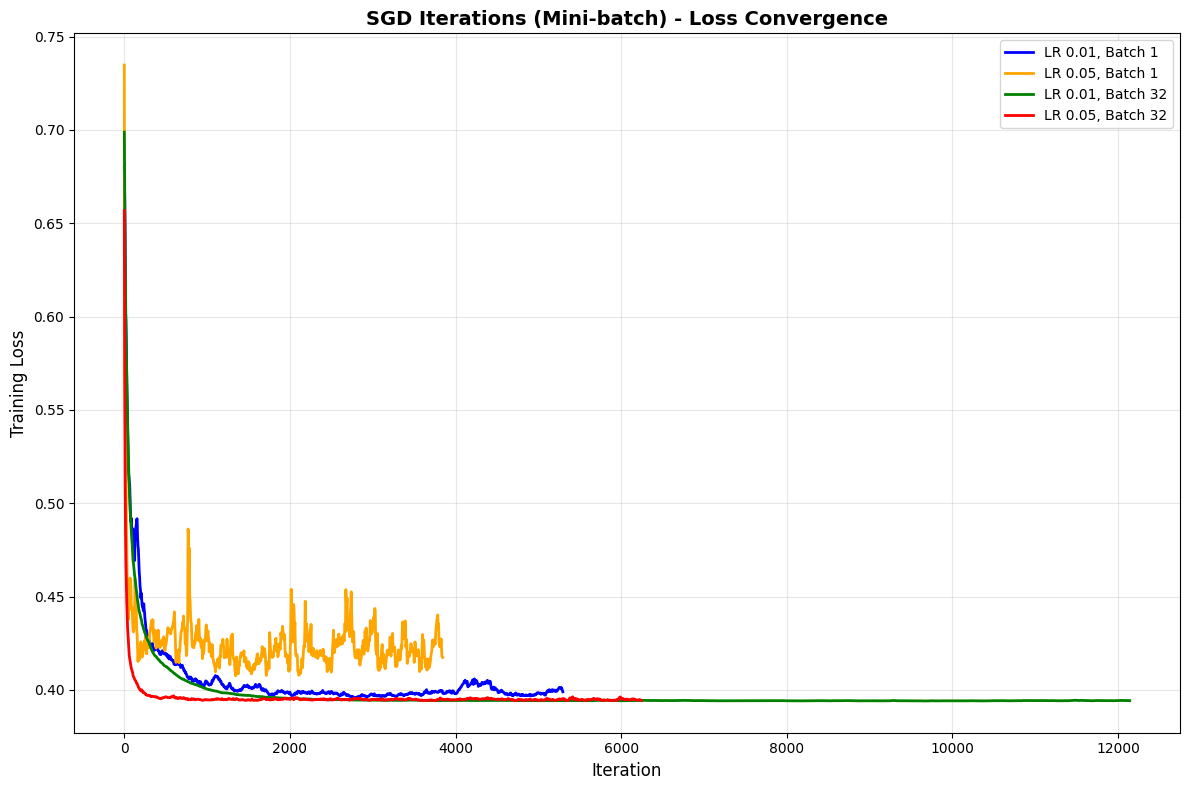

✅ SGD Iterations comparison saved!
{'final_loss': np.float64(0.3989799090076122), 'final_iteration': 5296, 'training_time': 53.9142701625824, 'learning_rate': 0.01, 'batch_size': 1}
{'final_loss': np.float64(0.4173632583900321), 'final_iteration': 3846, 'training_time': 38.53975009918213, 'learning_rate': 0.05, 'batch_size': 1}
{'final_loss': np.float64(0.3942298478604509), 'final_iteration': 12141, 'training_time': 121.82505941390991, 'learning_rate': 0.01, 'batch_size': 32}
{'final_loss': np.float64(0.3942945867163068), 'final_iteration': 6246, 'training_time': 62.742690563201904, 'learning_rate': 0.05, 'batch_size': 32}


In [22]:
# SGD Iterations (Mini-batch) - Loss Convergence Comparison
plt.figure(figsize=(12, 8))
sgd_iter_results: List[Dict[str, float]] = []

sgd_iter_configs = [
    {"lr": 0.01, "batch_size": 1, "color": "blue", "label": "LR 0.01, Batch 1"},
    {"lr": 0.05, "batch_size": 1, "color": "orange", "label": "LR 0.05, Batch 1"},
    {"lr": 0.01, "batch_size": 32, "color": "green", "label": "LR 0.01, Batch 32"},
    {"lr": 0.05, "batch_size": 32, "color": "red", "label": "LR 0.05, Batch 32"},
]

for config in sgd_iter_configs:
    model = WeightedLogisticRegression()
    optimizer = SGDIterationsOptimizer(
        learning_rate=config["lr"],
        batch_size=config["batch_size"],
        early_stop_patience=500,
        max_iterations=100000,
        log_interval=20,
        verbose=True,
    )
    
    result = optimizer.optimize(
        model, X_train_scaled, y_train,
        weights_train=weights_train
    )
    data: Dict[str, float] = {}
    data["final_loss"] = result["final_loss"]
    data["final_iteration"] = result["final_iteration"]
    data["training_time"] = result["training_time"]
    data["learning_rate"] = result["learning_rate"]
    data["batch_size"] = result["batch_size"]
    sgd_iter_results.append(data)
    
    plt.plot(result['iteration_history'], result['loss_history'], 
             color=config["color"], linewidth=2, label=config["label"])
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Training Loss", fontsize=12)
plt.title(
    "SGD Iterations (Mini-batch) - Loss Convergence", fontsize=14, fontweight="bold"
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(images_dir / "sgd_iterations_convergence.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ SGD Iterations comparison saved!")
for result in sgd_iter_results:
	print(result)

In [ ]:
# Summary: Display all saved images
print("=" * 80)
print("VISUALIZATION SUMMARY - WEIGHTED LOSS OPTIMIZATION COMPARISON")
print("=" * 80)
print(f"📁 All images saved to: {images_dir}")
print("📊 Generated visualizations:")
print("   1. sgd_fixed_lr_convergence.png - SGD with different learning rates")
print("   2. sgd_backtracking_convergence.png - SGD Backtracking with different initial rates")  
print("   3. sgd_iterations_convergence.png - SGD Iterations with different batch sizes")
print("   4. agd_fixed_lr_convergence.png - AGD with different LR/momentum combinations")
print("   5. agd_backtracking_convergence.png - AGD Backtracking with different initial rates")
print("\n✅ All optimization methods visualized with weighted loss function!")
print(f"✅ Using 'minute' field ({weights_train.min():.0f}-{weights_train.max():.0f}) as sample weights")
print("=" * 80)